In [ ]:
import urllib.request
from skimage import io, transform
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import numpy as np
from skimage import morphology, transform, util, color
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.spatial.distance import cdist
import math
from scipy.spatial import distance_matrix
from skimage.draw import line
import random
from scipy.spatial import distance
from scipy.ndimage.morphology import binary_dilation
import heapq

<ipython-input-1-7c70e693680d>:16: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


**# Task 1**

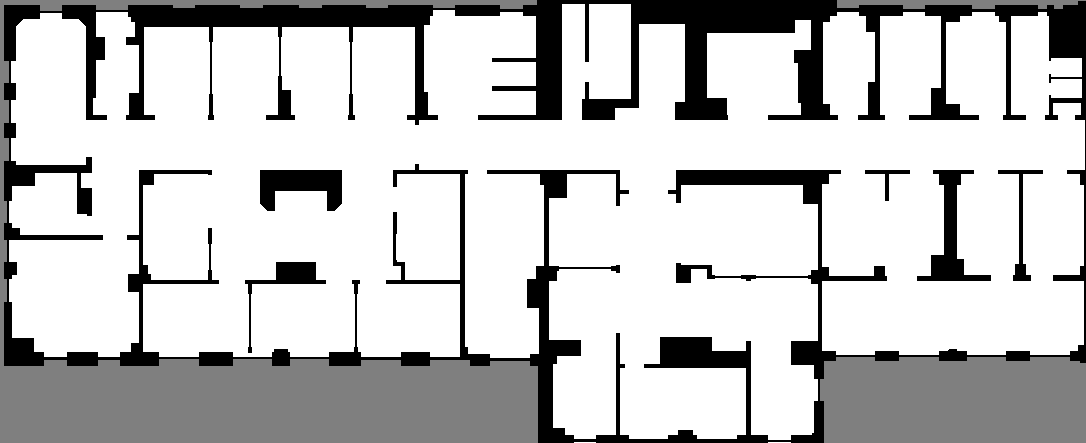

In [ ]:
#Get image url
url = "https://raw.githubusercontent.com/stdr-simulator-ros-pkg/stdr_simulator/indigo-devel/stdr_resources/maps/hospital_section.png"

#Load OGM and display
ogm = io.imread(url)
cv2_imshow(ogm)

**# Task 2**

In [ ]:
#Convert OGM to grayscale
ogm_2 = np.round(color.rgb2gray(ogm) * 255).astype(np.uint8)

brushfire = np.zeros_like(ogm_2)
brushfire[ogm_2 == 0] = 0  # obstacles
brushfire[ogm_2 == 255] = np.iinfo(np.int).max  # free spaces

#Define the 8 neighbors
neighbors = np.array([(i, j) for i in range(-1, 2) for j in range(-1, 2) if (i != 0) or (j != 0)])

#Initialize the queue with all obstacle pixels
queue = np.argwhere(brushfire == 0)

#Set the brushfire value of pixels on obstacles equal to 1
brushfire[queue[:, 0], queue[:, 1]] = 1

<ipython-input-3-0b98b13ff1dc>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  brushfire[ogm_2 == 255] = np.iinfo(np.int).max  # free spaces


In [ ]:
while queue.size > 0:
    # Get a pixel and remove it from the queue
    current = queue[0]
    queue = queue[1:]

    # Find the pixel's neighbors
    for n in neighbors:
        neighbor = current + n

        if 0 <= neighbor[0] < brushfire.shape[0] and 0 <= neighbor[1] < brushfire.shape[1]: #Check if the neighbor pixel is within the image boundaries
            new_value = brushfire[current[0], current[1]] + 1 #New brushfire value

            if brushfire[neighbor[0], neighbor[1]] > new_value: #If the neighbor has not been visited or if it has a higher brushfire value
                brushfire[neighbor[0], neighbor[1]] = new_value #Update the brushfire value

                # Add new pixel to the end of the queue
                queue = np.concatenate((queue, neighbor.reshape((1, 2))), axis=0)


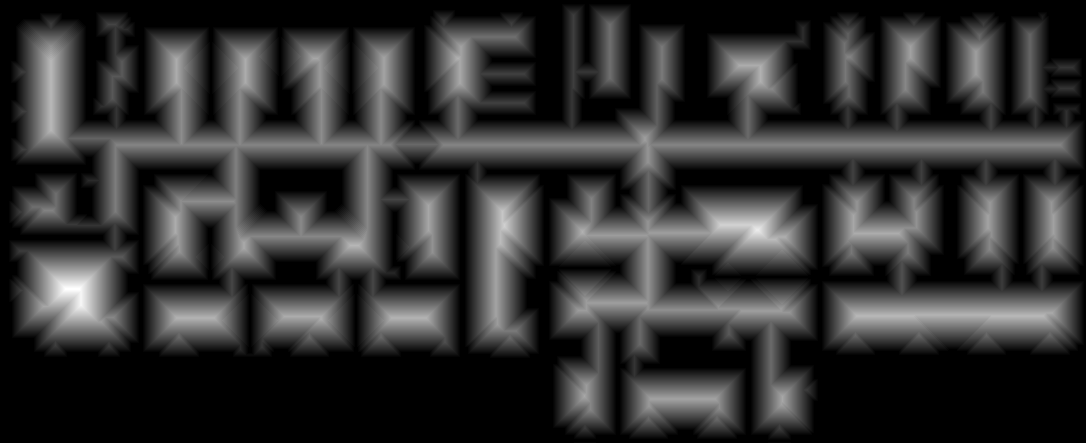

In [ ]:
#Display brushfire value field as an image
cv2_imshow(cv2.normalize(brushfire, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))

**# Task 3**

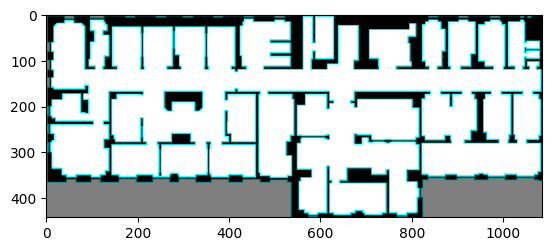

In [ ]:
#Add 6 more pixels (total 30 cm) around each obstacle for extra safety
extra_dist = 6

binary_ogm = np.zeros_like(ogm[:,:,0])
binary_ogm[ogm[:,:,0] < 0.5] = 1

# Binary dilation to add extra space around the obstacles
struct = np.ones((extra_dist, extra_dist))
dilated_ogm = binary_dilation(binary_ogm, structure=struct)

# Find the extra pixels
extra_pixels = dilated_ogm - binary_ogm

# Apply the extra pixels to the original OGM
modified_ogm = np.copy(ogm)
modified_ogm[:,:,0][extra_pixels == 1] = 0

plt.imshow(modified_ogm)
plt.show()

modified_ogm = np.round(color.rgb2gray(modified_ogm) * 255).astype(np.uint8)
modified_ogm[np.where(modified_ogm == 100)] = 0
modified_ogm[np.where(modified_ogm == 201)] = 0

In [ ]:
#Define the classes
class Node:
  def __init__(self, id):
    self.id = id
    self.x = None
    self.y = None
    self.neighbors = [] # list of ids
    self.cost = float('inf')
    self.heuristic = 0
    self.f_score = float('inf')

  def __lt__(self, other):
        return self.id < other.id

class Graph:
  def __init__(self):
    self.nodes = [] # list of Node instances

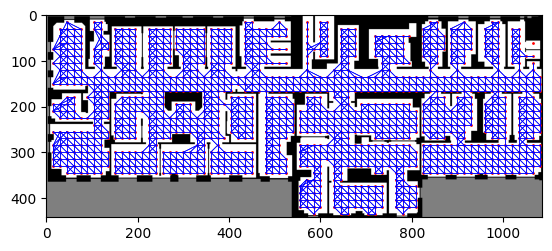

In [ ]:
# Convert OGM to binary
binary_ogm = np.zeros_like(modified_ogm)
binary_ogm[modified_ogm >= 200] = 1

# Step size for uniform sampling
step = 15
graph = Graph()

# Iterate over the grid with the step size
for i in range(0, binary_ogm.shape[0], step):
    for j in range(0, binary_ogm.shape[1], step):
        if binary_ogm[i, j] == 1:  #Check if the cell is considered free-space
            node = Node(len(graph.nodes)) #Create new node
            node.x = i
            node.y = j

            graph.nodes.append(node)

            # Find the shortest nodes to the [i,j] node
            existing_nodes_sorted = sorted(graph.nodes, key=lambda n: distance.euclidean([n.x, n.y], [node.x, node.y]))

            for existing_node in existing_nodes_sorted[:4]: #Check the 4 closest nodes
                if existing_node != node:
                    # Find the starting and ending point of the connecting line
                    start = np.array([existing_node.x, existing_node.y])
                    end = np.array([node.x, node.y])
                    line_points = np.linspace(start, end, max(abs(end[0] - start[0]), abs(end[1] - start[1])) + 1).astype(int) #Find all points of the connecting line

                    # Check if the connecting line is obstacle-free
                    if np.all(binary_ogm[line_points[:, 0], line_points[:, 1]] == 1):
                        # Add the node to the existing node neighbors
                        existing_node.neighbors.append(node.id)
                        # Add the existing node to the new node neighbors
                        node.neighbors.append(existing_node.id)
#Plot the image and the nodes
plt.imshow(ogm)
for node in graph.nodes:
    plt.plot(node.y, node.x, 'ro', markersize=1)

for node in graph.nodes:
    for neighbor_id in node.neighbors:
        neighbor = graph.nodes[neighbor_id]
        plt.plot([node.y, neighbor.y], [node.x, neighbor.x], 'b-', linewidth=0.5)

plt.show()


**# Task 4**

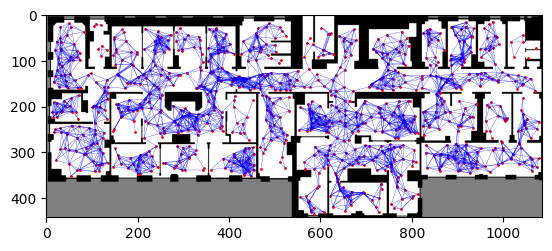

In [ ]:
# Convert OGM to binary
binary_ogm = np.zeros_like(modified_ogm)
binary_ogm[modified_ogm >= 200] = 1

graph = Graph()

# Define the  sampling density for the random sampling
sampling_density = 0.002

# Define proximity radius for connections
proximity_radius = 40

# Calculate the number of nodes based on the sampling density
num_nodes = int(binary_ogm.shape[0] * binary_ogm.shape[1] * sampling_density)

# Add random nodes to the graph if they are considered a free space
indices = np.argwhere(binary_ogm == 1)
for i in range(num_nodes):
    # Select a random index
    if len(indices) > 0:
        random_index = random.randint(0, len(indices) - 1)
        x, y = indices[random_index]
        node = Node(len(graph.nodes))
        node.x = x
        node.y = y

        graph.nodes.append(node)

        # Sort existing nodes by distance to the new node
        existing_nodes_within_radius = [n for n in graph.nodes if np.linalg.norm([n.x - node.x, n.y - node.y]) <= proximity_radius]

        # Connect the new node with the existing nodes within the radius
        for existing_node in existing_nodes_within_radius:
            if existing_node != node:
                # Get the start and end positions of the line connecting the nodes
                start = np.array([existing_node.x, existing_node.y])
                end = np.array([node.x, node.y])
                line_points = np.linspace(start, end, max(abs(end[0] - start[0]), abs(end[1] - start[1])) + 1).astype(int)

                # Check if the pixels on the connecting line are obstacle-free
                if np.all(binary_ogm[line_points[:, 0], line_points[:, 1]] == 1):
                    # Add the node to the existing node neighbors
                    existing_node.neighbors.append(node.id)
                    # Add the existing node to the new node neighbors
                    node.neighbors.append(existing_node.id)


#Plot
plt.imshow(ogm)
for node in graph.nodes:
    plt.plot(node.y, node.x, 'ro', markersize=1)
for node in graph.nodes:
    for neighbor_id in node.neighbors:
        neighbor = graph.nodes[neighbor_id]
        plt.plot([node.y, neighbor.y], [node.x, neighbor.x], 'b-', linewidth=0.1)
plt.show()


**# Task 5**

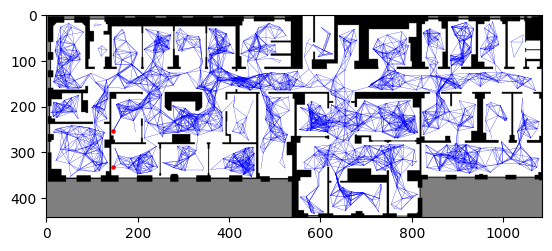

In [ ]:
# Randomly select start and goal nodes
def is_node_in_free_space(node, ogm):
    x, y = node.x, node.y
    return ogm[y, x] == 255

ogm_height, ogm_width = ogm_2.shape

start_node = None
goal_node = None

#Iterate random x,y until you find a random node of the graph. Doing so we will have 2 random nodes of our graph for start_node and goal_node
while True:
    start_node, goal_node = random.sample(graph.nodes, 2)
    if (0 <= start_node.x < ogm_width and 0 <= start_node.y < ogm_height) and \
       (0 <= goal_node.x < ogm_width and 0 <= goal_node.y < ogm_height) and \
       np.all([is_node_in_free_space(start_node, ogm), is_node_in_free_space(goal_node, ogm)]):
        break


#Show the start and goal nodes on the graph
plt.imshow(ogm)
for node in graph.nodes:
    plt.plot(node.y, node.x, 'g', markersize=1)
for node in graph.nodes:
    for neighbor_id in node.neighbors:
        neighbor = graph.nodes[neighbor_id]
        plt.plot([node.y, neighbor.y], [node.x, neighbor.x], 'b-', linewidth=0.1)
plt.scatter(start_node.y, start_node.x, s=5, c='r')
plt.scatter(goal_node.y, goal_node.x, s=5, c='r')
plt.show()

In [ ]:
#Define dijkstra algorithm
def dijkstra(start_node, goal_node, graph, ogm):
    #Set all distances to infinity except for our start node
    distances = {node.id: float('inf') for node in graph.nodes}
    distances[start_node.id] = 0
    # Initialize a dictionary to store the previous nodes
    preNodes = {}
    # Initialize priority queue
    queue = [(0, start_node)]
    # Initialize a list to keep track of expanded nodes
    expanded = []

    while queue:
        current_distance, current_node = heapq.heappop(queue)  # Extract the node with the minimum distance from the priority queue
        #Check if we found the goal node. If so, break
        if current_node.id == goal_node.id:
            break

        for neighbor_id in current_node.neighbors:
            neighbor = graph.nodes[neighbor_id]
            # Calclate the new distance by adding the Euclidean distance
            new_distance = current_distance + distance.euclidean((neighbor.x, neighbor.y), (current_node.x, current_node.y))

            if new_distance < distances[neighbor_id]:
                distances[neighbor_id] = new_distance
                preNodes[neighbor_id] = current_node.id
                # Inser neigbor to the priority queue with updated distance
                heapq.heappush(queue, (new_distance, neighbor))
        #Add it to the expanded list
        expanded.append(current_node)

    #If it doesn't find the goal node, return empty shortest path
    if goal_node.id not in preNodes:
        return expanded, []

    shortest_path = []
    current_node_id = goal_node.id
    #Reverse the shortest path, so it's oriented correctly
    while current_node_id != start_node.id:
        shortest_path.insert(0, current_node_id)
        current_node_id = preNodes[current_node_id]
    shortest_path.insert(0, start_node.id)
    #return the expanded list,and the shortest expansion of them all
    return expanded, shortest_path


In [ ]:
#Calling dijkstra and storing the outputs accordingly
all_paths, shortest = dijkstra(start_node, goal_node, graph, ogm_2)

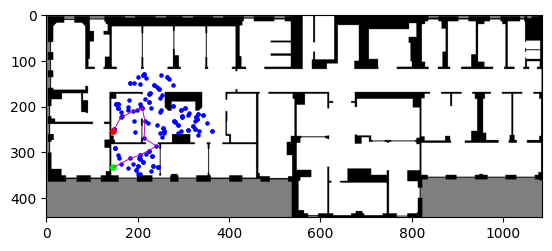

In [ ]:
# Plotting the grid map
plt.imshow(ogm)

#Plotting the shortest path
for i in range(len(shortest) - 1):
    node = graph.nodes[shortest[i]]
    next_node = graph.nodes[shortest[i + 1]]
    plt.plot([node.y, next_node.y], [node.x, next_node.x], 'm-', linewidth=0.7)


#Display the nodes of the expansions
for node in all_paths:
    plt.scatter(node.y, node.x, s=5, c='blue')  #Nodes as blue

#Scatter plot start node in lime and goal node in red
plt.scatter(start_node.y, start_node.x, s=15, c='lime')
plt.scatter(goal_node.y, goal_node.x, s=15, c='r')

#Display the plot
plt.show()



In [ ]:
#Define A*
def astar(start_node, goal_node, graph, ogm, heuristic_func):
    #Set all distances to infinity except for our start node
    distances = {node.id: float('inf') for node in graph.nodes}
    distances[start_node.id] = 0
    #Initialize preNodes dictionary to store previous nodes
    preNodes = {}
    queue = [(0, start_node)]
    # Initialize a list to store the expanded nodes
    expanded = []

    while queue:
        current_distance, current_node = heapq.heappop(queue)
        #Goal node is found then break
        if current_node.id == goal_node.id:
            break

        for neighbor_id in current_node.neighbors:
            neighbor = graph.nodes[neighbor_id]

            new_distance = current_distance + distance.euclidean((neighbor.x, neighbor.y), (current_node.x, current_node.y))

            if new_distance < distances[neighbor_id]:
                distances[neighbor_id] = new_distance
                preNodes[neighbor_id] = current_node.id

                # Calculate the heuristic value of the neighbor
                heuristic_value = heuristic_func(neighbor, goal_node)

                # For the neighbor node, input the new values
                neighbor.cost = new_distance
                neighbor.heuristic = heuristic_value
                neighbor.f_score = new_distance + heuristic_value
                # Add the neighbor to the queue
                heapq.heappush(queue, (neighbor.f_score, neighbor))

        expanded.append(current_node)
    #If goal node not reached, return empty shortest path
    if goal_node.id not in preNodes:
        return expanded, []

    #Reverse the shortest path
    shortest_path = []
    current_node_id = goal_node.id
    while current_node_id != start_node.id:
        shortest_path.insert(0, current_node_id)
        current_node_id = preNodes[current_node_id]
    shortest_path.insert(0, start_node.id)
    #Return expansions, and the shortest expansion
    return expanded, shortest_path





In [ ]:
#Define a heuristic function
def heuristic(current_node, goal_node):
    return distance.euclidean((current_node.y, current_node.x), (goal_node.y, goal_node.x))

In [ ]:
#Call A* using the heuristic function on ogm_2
all_paths, shortest = astar(start_node, goal_node, graph, ogm_2, heuristic)

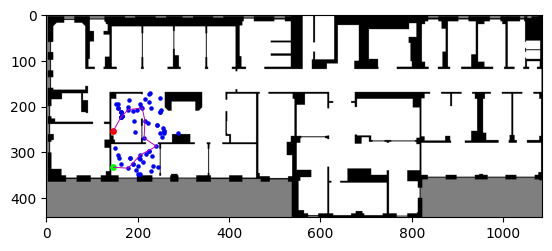

In [ ]:
#Plotting the grid map
plt.imshow(ogm)

#Plotting the shortest path
for i in range(len(shortest) - 1):
    node = graph.nodes[shortest[i]]
    next_node = graph.nodes[shortest[i + 1]]
    #Display a line connecting the current node and the next node
    plt.plot([node.y, next_node.y], [node.x, next_node.x], 'm-', linewidth=0.7)


#Display the nodes of the expansions
for node in all_paths:
    plt.scatter(node.y, node.x, s=5, c='blue')

#Scatter plot start node in lime and goal node in red
plt.scatter(start_node.y, start_node.x, s=15, c='lime')
plt.scatter(goal_node.y, goal_node.x, s=15, c='r')

#Display the plot
plt.show()

**# Task 6**

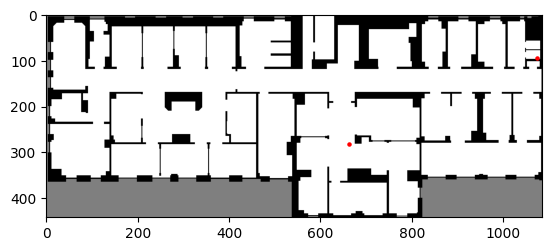

In [ ]:
def is_node_in_free_space(node, ogm): #Function to check if a node is in the free space
    x, y = node.x, node.y
    return ogm[y, x] == 255


# Randomly select start and goal node for RRT and RRT*
ogm_height, ogm_width = ogm_2.shape

start_node = Node(0)
while True:
    start_node.x = np.random.randint(0, ogm_width)
    start_node.y = np.random.randint(0, ogm_height)
    if is_node_in_free_space(start_node, ogm_2):
        break

goal_node = Node(1)
while True:
    goal_node.x = np.random.randint(0, ogm_width)
    goal_node.y = np.random.randint(0, ogm_height)
    if is_node_in_free_space(goal_node, ogm_2):
        break

# Show start and goal nodes on the map
plt.imshow(ogm)
plt.scatter(start_node.x, start_node.y, s=5, c='r')
plt.scatter(goal_node.x, goal_node.y, s=5, c='r')
plt.show()

In [ ]:
def get_nearest_node(graph, point):
    #Calculate the distances between the given point and all nodes
    distances = cdist([(point.x, point.y)], [(n.x, n.y) for n in graph.nodes])
    nearest_node_id = np.argmin(distances)
    return graph.nodes[nearest_node_id] # Return the nearest node from the graph

#Check if there is an obstacle in a path
def is_obstacle_in_path(node1, node2, ogm):
    x1, y1 = int(node1.x), int(node1.y)
    x2, y2 = int(node2.x), int(node2.y)

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = -1 if x1 > x2 else 1
    sy = -1 if y1 > y2 else 1
    err = dx - dy

    while x1 != x2 or y1 != y2:
        if ogm[y1, x1] <= 200:  # Check if the current point is an obstacle
            return True #If an obstacle is found, return True indicating that the path has obstacles

       # Based on the Bresenham's line algorithm, increase the coordinates of the point
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    #If no obstacles are found on the connecting line, return false
    return False


In [ ]:
def rrt(graph, start, goal, max_step, max_iterations, ogm):
    graph.nodes = [start]
    graph.parent = {start.id: None}

    for iteration in range(max_iterations):
        point = Node(len(graph.nodes))
        point.x = np.random.randint(0, ogm.shape[1])
        point.y = np.random.randint(0, ogm.shape[0])

        # Check if the sampled point is on an obstacle
        if not is_node_in_free_space(point, ogm):
            continue # Skip this iteration and generate a new random point

        # Find the minimum distance between the sampled point and existing nodes in the graph
        min_distance = float('inf')
        nearest_node_id = None
        for node in graph.nodes:
            distance = np.sqrt((node.x - point.x) ** 2 + (node.y - point.y) ** 2)
            if distance < min_distance:
                min_distance = distance
                nearest_node_id = node.id

        nearest_node = graph.nodes[nearest_node_id]
        dist = min_distance

        # Check if the connection between the nearest node and sampled point is obstacle-free
        if not is_obstacle_in_path(nearest_node, point, ogm):
            if dist <= max_step:
                # Extend the nearest node towards the point
                new_node = Node(len(graph.nodes))
                new_node.x = point.x
                new_node.y = point.y

                graph.nodes.append(new_node)

                # Connect the new node to the nearest node
                if not is_obstacle_in_path(nearest_node, new_node, ogm):
                    nearest_node.neighbors.append(new_node)
                    new_node.neighbors.append(nearest_node)
                    graph.parent[new_node.id] = nearest_node.id

                # Check if the new node is close to the goal node to connect them
                goal_dist = np.sqrt((new_node.x - goal.x) ** 2 + (new_node.y - goal.y) ** 2)
                if goal_dist <= max_step and not is_obstacle_in_path(goal, new_node, ogm):
                    goal.neighbors.append(new_node)
                    new_node.neighbors.append(goal)
                    graph.parent[goal.id] = new_node.id
                    return graph

    return graph


In [ ]:
graph = Graph()
max_step = 40
max_iterations = 100000

#Call RRT and store the graph
rrt_graph = rrt(graph, start_node, goal_node, max_step, max_iterations, modified_ogm)

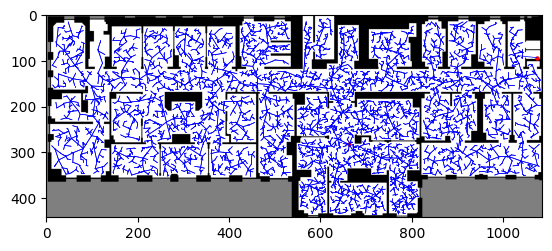

In [ ]:
# Plot the RRT graph
plt.imshow(ogm)

for node in rrt_graph.nodes:
    for neighbor in node.neighbors:
            plt.plot([node.x, neighbor.x], [node.y, neighbor.y], 'b-', linewidth=0.5)

plt.scatter(start_node.x, start_node.y, s=5, c='r')
plt.scatter(goal_node.x, goal_node.y, s=5, c='r')

plt.show()

In [ ]:
#Depth first algorithm to find a path on the RRT and RRT* graphs
def dfs(graph, start_node, goal_node):
    stack = [(start_node, [start_node])] #Add the start node and a path to the stack
    visited = set() #To keep track of visited nodes

    while stack:
        current_node, path = stack.pop() #Pop the top node from the stack

        if current_node == goal_node:
            return path

        visited.add(current_node)

        # Explore neighbors of the current node
        for neighbor in current_node.neighbors:
            if neighbor not in visited:
                stack.append((neighbor, path + [neighbor])) # Add the neighbor and the extended path to the stack

    return None # Return None if the goal node is not reachable from the start node

In [ ]:
#Find a path using the depth first algorithm
path_rrt = dfs(rrt_graph, start_node, goal_node)

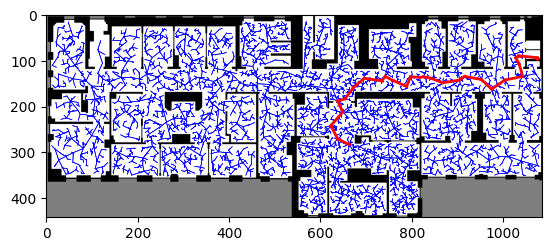

In [ ]:
plt.imshow(ogm)

# Plot the RRT graph
for node in rrt_graph.nodes:
    for neighbor in node.neighbors:
        plt.plot([node.x, neighbor.x], [node.y, neighbor.y], 'b-', linewidth=0.5)

# Plot start and goal nodes
plt.scatter(start_node.x, start_node.y, s=5, c='r')
plt.scatter(goal_node.x, goal_node.y, s=5, c='r')

# Plot the path
for i in range(len(path_rrt) - 1):
    node = path_rrt[i]
    neighbor = path_rrt[i + 1]
    plt.plot([node.x, neighbor.x], [node.y, neighbor.y], 'r-', linewidth=2)


plt.show()

**# Task 7**

In [ ]:
def rrt_star(graph, start, goal, max_step, max_iterations, ogm):
    graph.nodes = [start]
    graph.parent = {start.id: None}
    graph.cost = {start.id: 0.0}

    for iteration in range(max_iterations):
        # Randomly sample a point in the image
        point = Node(len(graph.nodes))
        point.x = np.random.randint(0, ogm.shape[1])
        point.y = np.random.randint(0, ogm.shape[0])

        # Check if the sampled point is on an obstacle
        if not is_node_in_free_space(point, ogm):
            continue

        # Find the minimum distance between the sampled point and existing nodes in the graph
        min_distance = float('inf')
        nearest_node_id = None
        for node in graph.nodes:
            distance = np.sqrt((node.x - point.x) ** 2 + (node.y - point.y) ** 2)
            if distance < min_distance:
                min_distance = distance
                nearest_node_id = node.id

        nearest_node = graph.nodes[nearest_node_id]
        dist = min_distance

        # Check if the connection between the nearest node and sampled point is obstacle-free
        if not is_obstacle_in_path(nearest_node, point, ogm):
            if dist <= max_step:
                new_node = Node(len(graph.nodes))
                new_node.x = point.x
                new_node.y = point.y

                parent_cost = graph.cost[nearest_node.id]
                cost = parent_cost + dist

                graph.cost[new_node.id] = cost
                graph.nodes.append(new_node)

                # Connect the new node to the nearest node
                if not is_obstacle_in_path(nearest_node, new_node, ogm):
                    nearest_node.neighbors.append(new_node)
                    graph.parent[new_node.id] = nearest_node.id
                    graph.cost[new_node.id] = cost

                # Find the neighbors of the new node within a radius of max_step
                neighbor_indices = []
                for node in graph.nodes:
                    neighbor_dist = np.sqrt((node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2)
                    if (neighbor_dist <= max_step) and not is_obstacle_in_path(node, new_node, ogm): #Make sure there are no obstacles in the path and that the distance is lower or equal to the max_step
                        neighbor_indices.append(node.id)

                # Connect the new node to the neighbors that result in shorter path
                for neighbor_id in neighbor_indices:
                    neighbor = graph.nodes[neighbor_id]
                    neighbor_dist = np.sqrt((neighbor.x - new_node.x) ** 2 + (neighbor.y - new_node.y) ** 2)
                    new_cost = graph.cost[new_node.id] + neighbor_dist #Update the cost of connecting the neighbor to the new_node

                    if (new_cost < graph.cost[neighbor_id]) and not is_obstacle_in_path(neighbor, new_node, ogm): #If the updated cost is smaller than the previous cost and there are not obstacles in the connecting line
                        if neighbor_id in graph.parent:
                            old_parent_id = graph.parent[neighbor_id]
                            if old_parent_id is not None:
                                old_parent = graph.nodes[old_parent_id] #Find the parent of the neighbor
                                old_parent.neighbors.remove(neighbor) #Remove the parent of the neighbor

                        new_node.neighbors.append(neighbor)
                        graph.parent[neighbor_id] = new_node.id  #Update the parent of the neighbor with the new node
                        graph.cost[neighbor_id] = new_cost

                # Calculate the cost for the new node from the start node
                new_node_cost = graph.cost[nearest_node.id] + dist
                graph.cost[new_node.id] = new_node_cost

                # Check if the new node is close to the goal node
                goal_dist = np.sqrt((new_node.x - goal.x) ** 2 + (new_node.y - goal.y) ** 2)
                goal_cost = new_node_cost + goal_dist
                if goal_dist <= max_step and not is_obstacle_in_path(goal, new_node, ogm): #Ensure there are no obstacles in the connecting line
                    if (goal.id not in graph.parent) or (goal_cost < graph.cost[goal.id]):
                        new_node.neighbors.append(goal)
                        graph.parent[goal.id] = new_node.id
                        graph.cost[goal.id] = goal_cost
                        return graph  #If goal node connected to the graph, then exit the algorithm

    return graph


In [ ]:
graph_2 = Graph()
max_step = 60
max_iterations = 15000

#Call RRT* and store the graph
rrt_star_graph = rrt_star(graph_2, start_node, goal_node, max_step, max_iterations, modified_ogm)

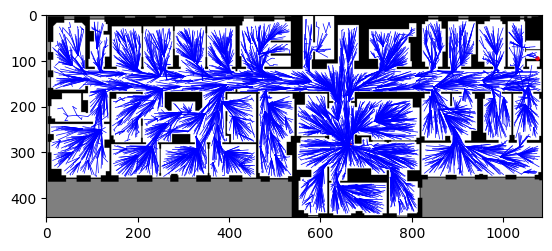

In [ ]:
plt.imshow(ogm)

for node in rrt_star_graph.nodes:
    for neighbor in node.neighbors:
            plt.plot([node.x, neighbor.x], [node.y, neighbor.y], 'b-', linewidth=0.5)

plt.scatter(start_node.x, start_node.y, s=5, c='r')
plt.scatter(goal_node.x, goal_node.y, s=5, c='r')

plt.show()

In [ ]:
#Find a path using the depth first algorithm
path_rrt_star = dfs(rrt_star_graph, start_node, goal_node)

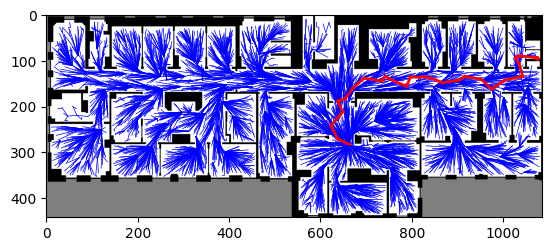

In [ ]:
plt.imshow(ogm)

# Plot the RRT* graph
for node in rrt_star_graph.nodes:
    for neighbor in node.neighbors:
        plt.plot([node.x, neighbor.x], [node.y, neighbor.y], 'b-', linewidth=0.5)

# Plot start and goal nodes
plt.scatter(start_node.x, start_node.y, s=5, c='r')
plt.scatter(goal_node.x, goal_node.y, s=5, c='r')

# Plot the path
for i in range(len(path_rrt_star) - 1):
    node = path_rrt_star[i]
    neighbor = path_rrt_star[i + 1]
    plt.plot([node.x, neighbor.x], [node.y, neighbor.y], 'r-', linewidth=2)


plt.show()

**#Task 8**

In [ ]:
def smooth_path(path, ogm, iterations=20, alpha=0.5):
    smoothed_path = path.copy()

    for _ in range(iterations):
        for i in range(1, len(smoothed_path) - 1): # Iterate over the nodes in the path
            current_node = smoothed_path[i] # Current node to be smoothed
            prev_node = smoothed_path[i - 1]  # Previous node
            next_node = smoothed_path[i + 1]  # Following node

            # Find the average x and y between two consecutive nodes
            average_node_x = (prev_node.x + next_node.x) / 2
            average_node_y = (prev_node.y + next_node.y) / 2

            # Update the current node based on the average and the smoothing factor
            new_x = current_node.x + alpha * (average_node_x - current_node.x)
            new_y = current_node.y + alpha * (average_node_y - current_node.y)

            new_node = Node(0)
            new_node.x = new_x
            new_node.y = new_y
            if is_obstacle_in_path(prev_node, new_node, ogm) or is_obstacle_in_path(new_node, next_node, ogm): # Check if the new position falls on an obstacle
                continue

            # Create a new node with the updated position
            smoothed_node = Node(current_node.id)
            smoothed_node.x = new_x
            smoothed_node.y = new_y

            # Replace the current node with the smoothed node
            smoothed_path[i] = smoothed_node

    return smoothed_path


In [ ]:
smoothed_path = smooth_path(path_rrt, modified_ogm)

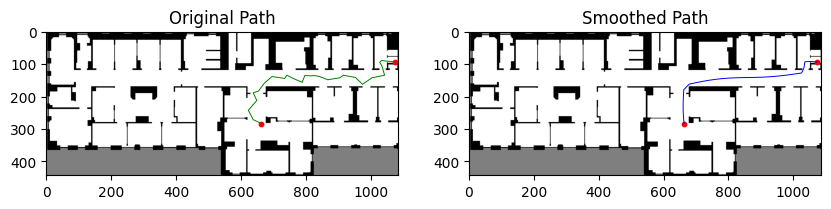

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original path
axs[0].imshow(ogm, cmap='gray')
axs[0].plot([node.x for node in path_rrt], [node.y for node in path_rrt], color='green', linewidth=0.7)
axs[0].scatter(start_node.x, start_node.y, s=10, c='red')
axs[0].scatter(goal_node.x, goal_node.y, s=10, c='red')
axs[0].set_title('Original Path')

# Plot smoothed path
axs[1].imshow(ogm, cmap='gray')
axs[1].plot([node.x for node in smoothed_path], [node.y for node in smoothed_path], color='blue', linewidth=0.7)
axs[1].scatter(start_node.x, start_node.y, s=10, c='red')
axs[1].scatter(goal_node.x, goal_node.y, s=10, c='red')
axs[1].set_title('Smoothed Path')

plt.show()
